# Calibrating the Direct CNOT gate

In [1]:
import logging
from copy import deepcopy
import warnings
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from qiskit.circuit import Gate
from qiskit import transpile
from qiskit.transpiler import InstructionProperties
from qiskit_utilities import (
    save_job_data,
    setup_logger,
    get_cr_schedule,
    iy_drag_calibration,
    get_default_cr_params,
    read_calibration_data,
    create_direct_cnot_schedule,
    rough_rz0_correction_calibration,
    fine_rz0_correction_calibration,
    initilize_qiskit_dynamics_backend
)
session = None  # qiskit runtime session

/local/bli/conda/qiskit-dynamics/lib/python3.12/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
# Setup a logging system.
setup_logger(filename=None, level=logging.INFO, stdout=True)
logger = logging.getLogger("qiskit_utilities")

2024-01-10 11:42:42,385, MainThread 
INFO Logger initialized successfully.


In [3]:
# Create a qiskit-dynamics backend with two Transmon, see fake_backend.py for detail.
# fidelity
f0 = 5.188339840468758e9
f1 = 5.079647268847252e9
# anharmonicity
a0 = -0.341931669003125e9
a1 = -0.343248404293835e9
backend = initilize_qiskit_dynamics_backend(f0, f1, a0, a1)

/local/bli/conda/qiskit-dynamics/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in std_dev (vectorized)
  outputs = ufunc(*inputs)


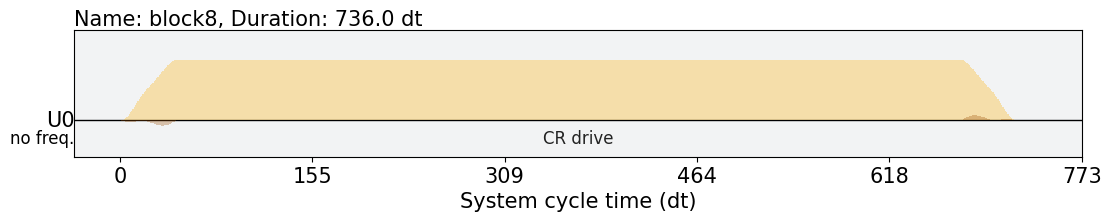

In [4]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Multiple the amplitude by a ratio factor.
ratio = 1
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4 / ratio
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)

# Custom shape
gate_name = "CR-recursive-tr10-direct"
params = {
    "order": "3",  # order m for the initial pulse shape
    "t_r": 10,
    "drag_type" : "exact",  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"
ix_params["drag_type"] = "01"  # single-derivative DRAG

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}

get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-01-10 11:43:47,829, MainThread 
INFO 

CR calibration round 1: 
2024-01-10 11:44:06,097, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:45:33,764, MainThread 
INFO CR tomography: 41df0fe4-52fe-477a-aa0e-499c3d419c56
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0

2024-01-10 11:45:33,978, MainThread 
INFO Job saved to data/41df0fe4-52fe-477a-aa0e-499c3d419

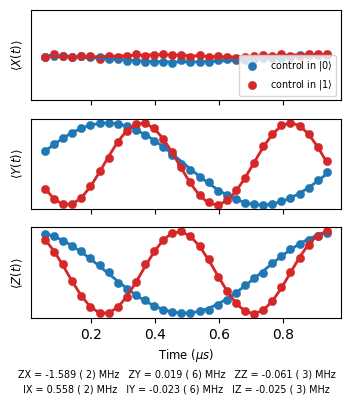

2024-01-10 11:45:34,517, MainThread 
INFO Tomography results:
{'IX': 0.5581303046586221, 'IY': -0.022887258609044833, 'IZ': -0.024672696393830393, 'ZX': -1.5888174965380697, 'ZY': 0.0191109006150325, 'ZZ': -0.06098357036440083}

2024-01-10 11:45:34,518, MainThread 
INFO Remaining dominant error: IX: 0.5581303046586221 MHz

2024-01-10 11:45:53,202, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:47:15,672, MainThread 
INFO CR tomography: 5cdc274c-7023-45d6-9ea9-46bf33894a4b
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 

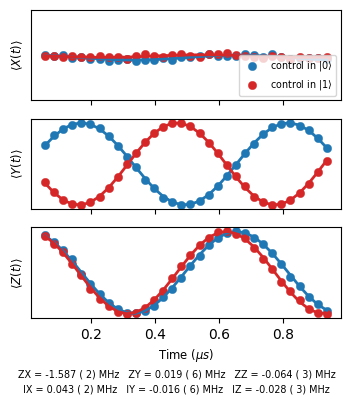

2024-01-10 11:47:16,367, MainThread 
INFO {'IX': 0.04319956505650652, 'IY': -0.016319624447641658, 'IZ': -0.027615133644078207, 'ZX': -1.5874039528736164, 'ZY': 0.01896707321658626, 'ZZ': -0.0640611084721207}
2024-01-10 11:47:16,368, MainThread 
INFO Frequency offset is updated to -24672.696393830392 Hz
2024-01-10 11:47:16,369, MainThread 
INFO 

CR calibration round 2: 
2024-01-10 11:47:35,525, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:48:55,789, MainThread 
INFO CR tomography: 1d21b9da-cdad-4e41-abda-239f4b1f034a
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.012027799964043738, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
i

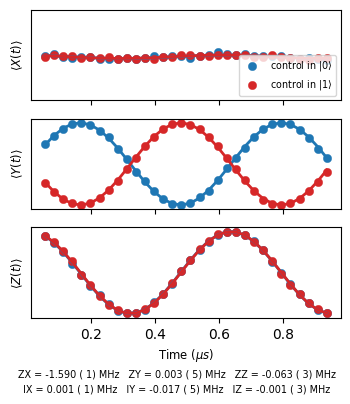

2024-01-10 11:48:56,458, MainThread 
INFO Tomography results:
{'IX': 0.0010412903660916408, 'IY': -0.016805800345928414, 'IZ': -0.001283976911222869, 'ZX': -1.5899959396299952, 'ZY': 0.002601483913925118, 'ZZ': -0.06316458723784642}

2024-01-10 11:48:56,458, MainThread 
INFO Remaining dominant error: IY: 0.016805800345928414 MHz

2024-01-10 11:49:14,385, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:50:34,547, MainThread 
INFO CR tomography: 5206f85d-12af-4ee5-b09e-b8101295779a
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.012027799964043738, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_

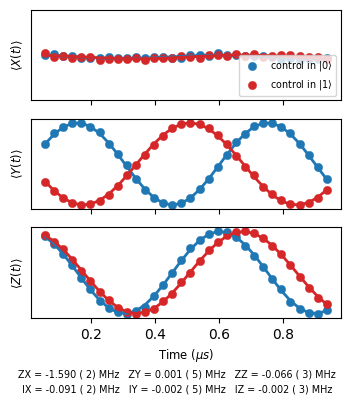

2024-01-10 11:50:35,242, MainThread 
INFO {'IX': -0.09072072222358409, 'IY': -0.0023334567381755296, 'IZ': -0.0020170016236716604, 'ZX': -1.589720521581657, 'ZY': 0.001115552243716584, 'ZZ': -0.06628346359118574}
2024-01-10 11:50:35,243, MainThread 
INFO 

CR calibration round 3: 
2024-01-10 11:50:54,218, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:52:15,450, MainThread 
INFO CR tomography: 0787cd0c-b62b-4b22-88fc-f1567ea7ee95
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0035283698

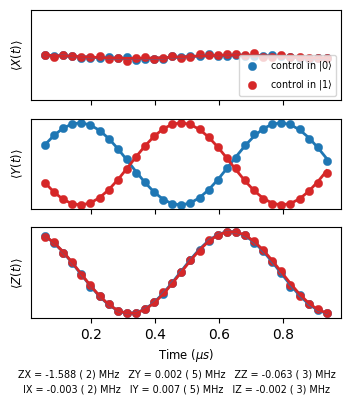

2024-01-10 11:52:16,171, MainThread 
INFO Tomography results:
{'IX': -0.0028685050109341333, 'IY': 0.006989032507715094, 'IZ': -0.0021951531705395816, 'ZX': -1.5883305583338878, 'ZY': 0.0017290034625914014, 'ZZ': -0.06277654951100464}

2024-01-10 11:52:16,172, MainThread 
INFO Remaining dominant error: IY: 0.006989032507715094 MHz

2024-01-10 11:52:16,172, MainThread 
INFO Successfully calibrated.


In [5]:
from qiskit_utilities import iterative_cr_pulse_calibration
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,
    max_repeat=3,
    rerun_last_calibration=True,
    shots=2048,
    mode="CR",
    )

2024-01-10 11:52:16,182, MainThread 
INFO 
Calibrating the IY-DRAG pulse for (0, 1)-CR-recursive-tr10-direct.
2024-01-10 11:52:35,191, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:53:56,424, MainThread 
INFO CR tomography: 46dc2a31-37f6-4ac9-8019-d2ffff8484ee
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003528369850505967, 'angle': 0.04366093208987135, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 0.0}
x_gate_ix_params: None
frequency_

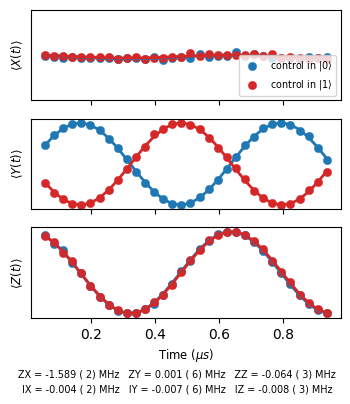

2024-01-10 11:54:15,968, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:55:36,770, MainThread 
INFO CR tomography: 58ba5c29-6fd7-4fa4-b2fb-e32bf36e167d
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003528369850505967, 'angle': 0.04366093208987135, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': -2.0}
x_gate_ix_params: None
frequency_offset: -24672.696393830392

2024-01-10 11:55:36,970, MainThread 
INFO Job saved to data/58ba5c29-6fd7-4fa4-b

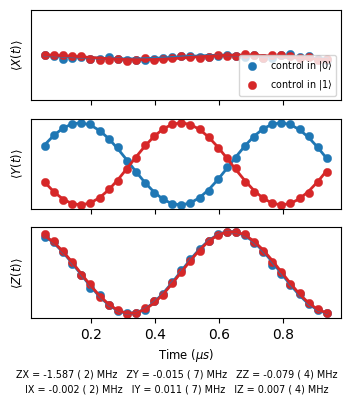

2024-01-10 11:55:56,078, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:57:17,118, MainThread 
INFO CR tomography: a30626d3-1b6c-4909-a115-aa3a26e434e1
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003528369850505967, 'angle': 0.04366093208987135, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 2.0}
x_gate_ix_params: None
frequency_offset: -24672.696393830392

2024-01-10 11:57:17,344, MainThread 
INFO Job saved to data/a30626d3-1b6c-4909-a1

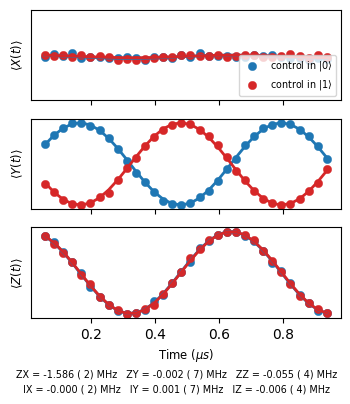

2024-01-10 11:57:17,807, MainThread 
INFO ZZ sampling measurements complete : [-0.06384567903158173, -0.07865709994973769, -0.055297544733929956].

2024-01-10 11:57:17,809, MainThread 
INFO Calibrated IY beta: 11.290187784705488



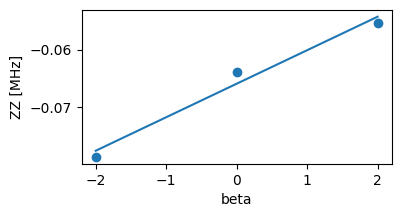

2024-01-10 11:57:37,293, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 11:58:59,194, MainThread 
INFO CR tomography: a20dcce2-2c50-4c4d-8d75-f2c46e11d5b9
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003528369850505967, 'angle': 0.04366093208987135, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 11.290187784705488}
x_gate_ix_params: None
frequency_offset: -24672.696393830392

2024-01-10 11:58:59,430, MainThread 
INFO Job saved to data/a20dcc

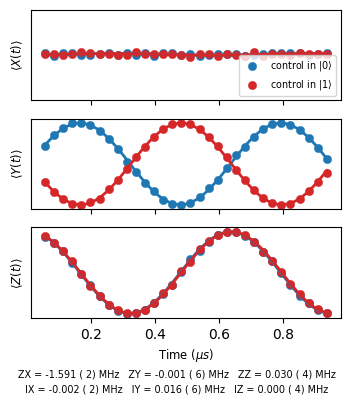

2024-01-10 11:58:59,891, MainThread 
INFO Updated coupling strength: {'IX': -0.0018542945518979306, 'IY': 0.015919783849260717, 'IZ': 0.00022957945051500856, 'ZX': -1.590924007629355, 'ZY': -0.0011169343642872037, 'ZZ': 0.02951093559464129}
2024-01-10 11:58:59,894, MainThread 
INFO IY-DRAG calibration complete, new calibration data saved.


In [6]:
iy_drag_calibration((QUBIT_C, QUBIT_T), backend, gate_name, cr_times, session, verbose=True, delta_beta=10.)

## Calibrating the target drive for a direct CNOT

On top of the calibration above, we add a pulse on resonant with the target qubit such that $\nu_{ZX}=\nu_{IX}$. Calibration data is saved under the tag "x_gate_ix_params", This ensures that the target qubit only rotates if the control is in state $|1\rangle$.

Therefore, we aim at setting the target qubit tomography to $\nu_{X}=\nu_{IX}+\nu_{ZX}==2\nu_{ZX}$.

2024-01-10 11:58:59,905, MainThread 
WARNING Last calibration job for CR-recursive-tr10-direct not found or not used. Starting from scratch.
2024-01-10 11:58:59,906, MainThread 
INFO Loading existing calibration data...
2024-01-10 11:58:59,908, MainThread 
INFO 

CR calibration round 1: 
2024-01-10 11:59:27,971, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 12:00:45,012, MainThread 
INFO CR tomography: 89f97af5-3653-4a0a-8251-7fda8292865c
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224 4352 4480 4608 4736 4864 4992 5120 5248 5376 5504
 5632]
shots: 8096
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r

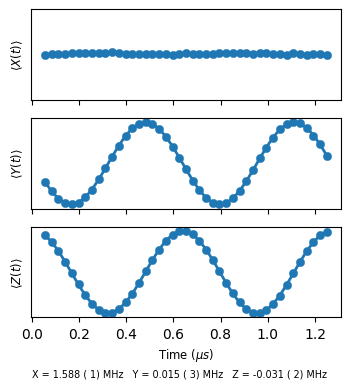

2024-01-10 12:00:45,652, MainThread 
INFO Tomography results:
{'IX': 1.5875890433737054, 'IY': 0.01527573410895695, 'IZ': -0.03076997990875393}

2024-01-10 12:00:45,653, MainThread 
INFO Remaining dominant error: IX: 1.5942589718850044 MHz

2024-01-10 12:01:13,207, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 12:02:27,489, MainThread 
INFO CR tomography: cf737a39-74db-4ee2-b836-a01fd4c3e221
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224 4352 4480 4608 4736 4864 4992 5120 5248 5376 5504
 5632]
shots: 8096
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp'

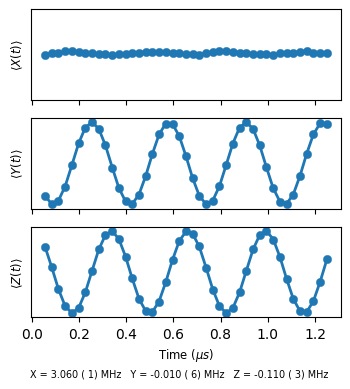

2024-01-10 12:02:28,131, MainThread 
INFO {'IX': 3.059675177637617, 'IY': -0.009996478713184485, 'IZ': -0.11019254435333707}
2024-01-10 12:02:28,132, MainThread 
INFO 

CR calibration round 2: 
2024-01-10 12:02:55,593, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 12:04:10,252, MainThread 
INFO CR tomography: 87f69121-12de-4b82-ac46-a31683cb6798
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224 4352 4480 4608 4736 4864 4992 5120 5248 5376 5504
 5632]
shots: 8096
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003528369850505967, 'angle': 0.04366093208

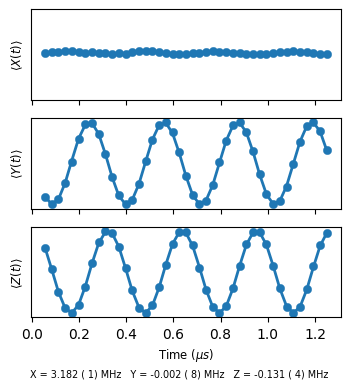

2024-01-10 12:04:10,914, MainThread 
INFO Tomography results:
{'IX': 3.1817267708013226, 'IY': -0.0015667109530861302, 'IZ': -0.13143448539985986}

2024-01-10 12:04:10,914, MainThread 
INFO Remaining dominant error: IY: 0.0015667109530861302 MHz

2024-01-10 12:04:10,915, MainThread 
INFO Successfully calibrated.


In [7]:
# Reduce cr_times by a half
if backend.name == 'DynamicsBackend':
    cr_times = np.arange(16*16, 1440*4, 32*4, dtype=int)
else:
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4 / ratio / 2
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)
from qiskit_utilities import iterative_cr_pulse_calibration
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    cr_times,
    session,
    gate_name=gate_name,
    initial_calibration_data=None,
    verbose=True,
    threshold_MHz=0.015,
    restart=True,
    rerun_last_calibration=False,
    max_repeat=3,
    shots=8096,
    mode="IX-pi"
    )

## Calibrating the ZI phase

So far we only created a CR operation, the drive on the control qubit will accumulate a phase. Since the phase commute with the CR operation, it can be cancelled by adding a RZ rotation on the control at the end of the pulse.

2024-01-10 12:04:10,924, MainThread 
INFO Rough calibration of the RZ0 phase correction.
2024-01-10 12:06:55,034, MainThread 
INFO ZI calibration ID: dfb76c02-41e5-44a3-a2c5-3dc96ab2bd7e
name: rz0 calibration
backend: DynamicsBackend
qubits: (0, 1)
phase_list: [-3.14159265 -3.01336438 -2.88513611 -2.75690784 -2.62867957 -2.5004513
 -2.37222302 -2.24399475 -2.11576648 -1.98753821 -1.85930994 -1.73108167
 -1.60285339 -1.47462512 -1.34639685 -1.21816858 -1.08994031 -0.96171204
 -0.83348377 -0.70525549 -0.57702722 -0.44879895 -0.32057068 -0.19234241
 -0.06411414  0.06411414  0.19234241  0.32057068  0.44879895  0.57702722
  0.70525549  0.83348377  0.96171204  1.08994031  1.21816858  1.34639685
  1.47462512  1.60285339  1.73108167  1.85930994  1.98753821  2.11576648
  2.24399475  2.37222302  2.5004513   2.62867957  2.75690784  2.88513611
  3.01336438  3.14159265]
shots: 1024

2024-01-10 12:06:55,289, MainThread 
INFO Job saved to data/dfb76c02-41e5-44a3-a2c5-3dc96ab2bd7e

2024-01-10 12:06:55

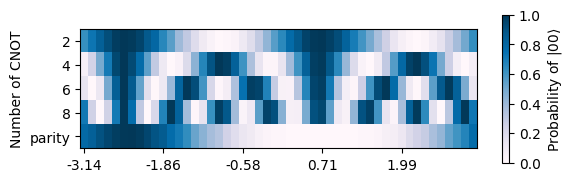

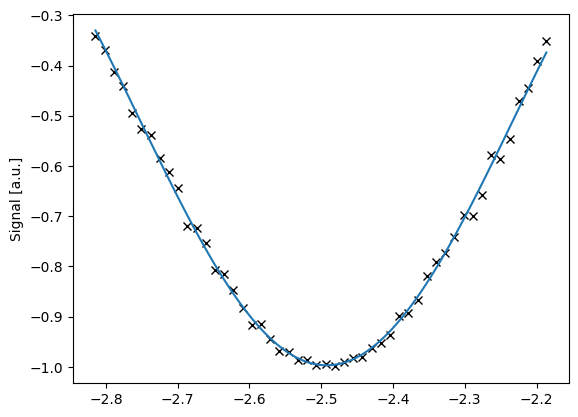

In [8]:
rough_rz0_correction_calibration(backend, (QUBIT_C, QUBIT_T), gate_name, session)
fine_rz0_correction_calibration(backend, (QUBIT_C, QUBIT_T), gate_name, session)

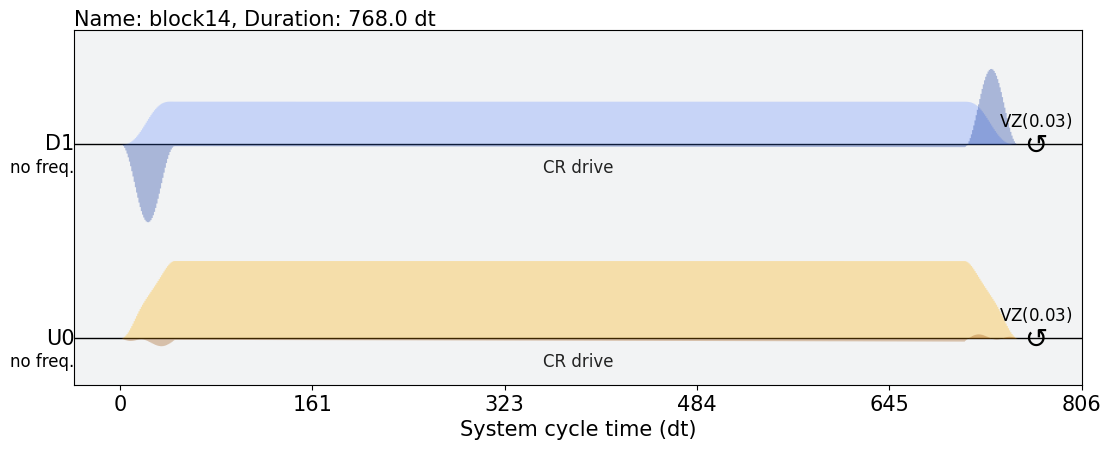

In [9]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))
custom_cnot_sched = create_direct_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)
# Show the custom CNOT schedule.
custom_cnot_sched.draw()

In [10]:
custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots=8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, exp=qptexp, parameters=parameters)

2024-01-10 12:08:11,201, MainThread 
INFO Quantum process tomography job: 1b1aa2b6-d8a4-4898-a834-44d9fa973e5c
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-01-10 12:08:11,488, MainThread 
INFO Job saved to data/1b1aa2b6-d8a4-4898-a834-44d9fa973e5c



In [11]:
from qiskit_utilities import load_job_data
def retrive_expdata(job, backend):
    """
    Retrieve qiskit-experiment data associated with a job ID and backend.

    Args:
        job (str): Job ID of the executed job.
        backend (IBMQBackend): The backend used for the job.

    Returns:
        ExperimentData: Experimental data associated with the job.
    """
    job_data = load_job_data(job)
    exp = job_data["exp"]
    expdata = exp._initialize_experiment_data()
    if isinstance(job, str) and backend.name=="DynamicsBackend":
        raise ValueError("For DynamicsBackend, please provides the job instance.")
    elif backend.name=="DynamicsBackend":
        expdata.add_jobs([job])
    else:
        expdata.add_jobs([backend.job(job)])
    expdata = exp.analysis.run(expdata).block_for_results()
    return expdata


(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

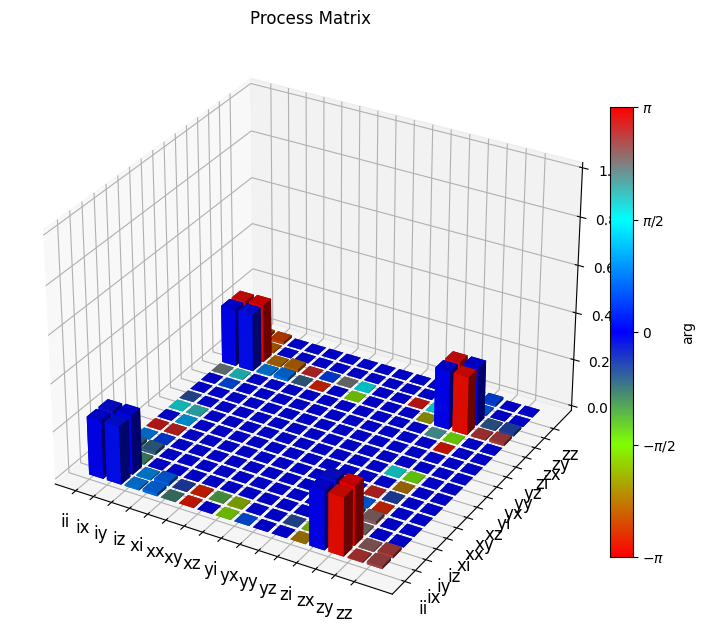

In [12]:
import qutip
from qutip.qip.operations import cnot
qptdata = retrive_expdata(qpt_job, backend=backend)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.choi_to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi = qutip.qpt(qutip.choi_to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

## Randomized benchmakring

Since randomized benchmarking is very slow with the pulse simulator, we only perform RB up to 60 Clifford. The following cell takes approximately 1.5 hours.

In [13]:
from qiskit.circuit.library import CXGate
from qiskit_experiments.library import InterleavedRB


mode = "with_correction"
direct = True
if mode not in ("with_correction", "without_correction", "default"):
    raise ValueError("Unknown mode.")
backend_tmp = deepcopy(backend)
rb_gate = CXGate()
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))
if mode != "default":
    modified_calibration_data = deepcopy(calibration_data)
    if mode == "without_correction":
        modified_calibration_data["ix_params"]["beta"] = 0.
        modified_calibration_data["frequency_offset"] = 0.
        modified_calibration_data["x_gate_frequency_offset"] = 0.
    # Direct gate
    custom_cnot_sched = create_direct_cnot_schedule(backend, (QUBIT_C, QUBIT_T), modified_calibration_data, with_separate_x=False)
    backend_tmp.target["cx"][(QUBIT_C, QUBIT_T)] = InstructionProperties(calibration=custom_cnot_sched)

    custom_cnot_sched = create_direct_cnot_schedule(backend, (QUBIT_C, QUBIT_T), modified_calibration_data, with_separate_x=False, reverse_direction=True)
    backend_tmp.target["cx"][(QUBIT_T, QUBIT_C)] = InstructionProperties(calibration=custom_cnot_sched)


seed = np.random.randint(2**16)
num_sampling = 30
lengths = [1, 10, 20, 30, 40, 50, 60]

irb_exp = InterleavedRB(
    interleaved_element=rb_gate, physical_qubits=[QUBIT_C, QUBIT_T], lengths=lengths, num_samples=num_sampling, backend=backend_tmp, seed=seed)

transpiled_circ_list = transpile(
    # One must use _transpiled_circuits because it will include the calibration
    irb_exp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates= ["x", "sx", "rz", "cx"], #+ ["custom_cnot"],
    # initial_layout = [QUBIT_C, QUBIT_T],  # Map the circuit to the target qubits
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )
shots = 4096
rb_job = backend_tmp.run(
    transpiled_circ_list,
    shots=shots,
    )
parameters = {
    "backend": backend.name,
    "mode": mode,
    "with_separate_x": False,
    "direct": direct,
    "qubits": [QUBIT_C, QUBIT_T],
    "gate": rb_gate.name,
    "shots": shots,
    "lengths": lengths,
    "num_sampling": num_sampling,
    "seed": seed,
    "calibration_data": calibration_data,
    }
logger.info(
    "Randomized benchmarking job: "+
    str(rb_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )
save_job_data(rb_job, backend=backend, parameters=parameters)


2024-01-10 13:34:57,174, MainThread 
INFO Randomized benchmarking job: ed30fcb8-8aeb-451c-9f37-e9efd43c0c80
backend: DynamicsBackend
mode: with_correction
with_separate_x: False
direct: True
qubits: [0, 1]
gate: cx
shots: 4096
lengths: [1, 10, 20, 30, 40, 50, 60]
num_sampling: 30
seed: 52841
calibration_data: {'cr_params': {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.013663956087268385, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}, 'ix_params': {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003528369850505967, 'angle': 0.04366093208987135, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 11.290187784705488}, 'frequency_offset': -24672.696393830392, 'calibration_job_id': 'a20dcce2-2c50-4c4d-8d75-f2c46e11d5b9', 'coeffs': {'IX': -0.0018542945518979306, 'IY': 0.015919783849260717, 'IZ': 0.00022957945051500856, 'ZX': -1.59

In [14]:
def retrive_expdata(job, backend, exp):
    """
    Retrieve qiskit-experiment data associated with a job ID and backend.

    Args:
        job (str): Job ID of the executed job.
        backend (IBMQBackend): The backend used for the job.

    Returns:
        ExperimentData: Experimental data associated with the job.
    """
    expdata = exp._initialize_experiment_data()
    if isinstance(job, str) and backend.name=="DynamicsBackend":
        pass
        # raise ValueError("For DynamicsBackend, please provides the job instance.")
    elif backend.name=="DynamicsBackend":
        expdata.add_jobs([job])
    else:
        expdata.add_jobs([backend.job(job)])
    
    expdata = exp.analysis.run(expdata).block_for_results()
    return expdata

from qiskit_utilities import load_job_data
parameters = load_job_data(rb_job)["parameters"]
exp_rb = InterleavedRB(
    interleaved_element=CXGate(),
    physical_qubits=[QUBIT_C, QUBIT_T],
    lengths=parameters["lengths"],
    num_samples=parameters["num_sampling"],
    backend=backend,
    seed=parameters["seed"])
exp_data = retrive_expdata(rb_job, backend, exp=exp_rb)

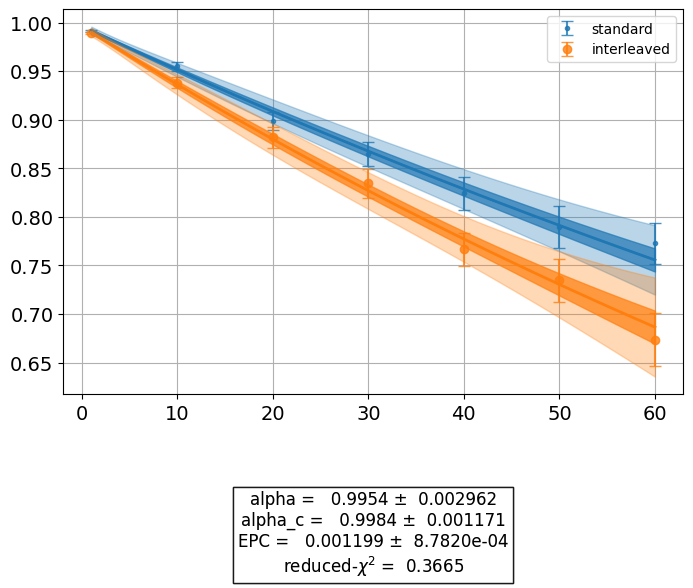

In [15]:
exp_data.figure(0)

The measured fidelity has a relatively large error because we only simulated up to 60 Clifford gates. In experiment it would be better to include 200 to 300 Cliffords. Nevertheless, one can still get a rough estimation of the RB fidelity.